In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
TICKER = "SBER"
df = pd.read_csv(f"../download_data/data/day_candles/{TICKER}.csv")

In [11]:
import warnings
warnings.simplefilter("ignore")

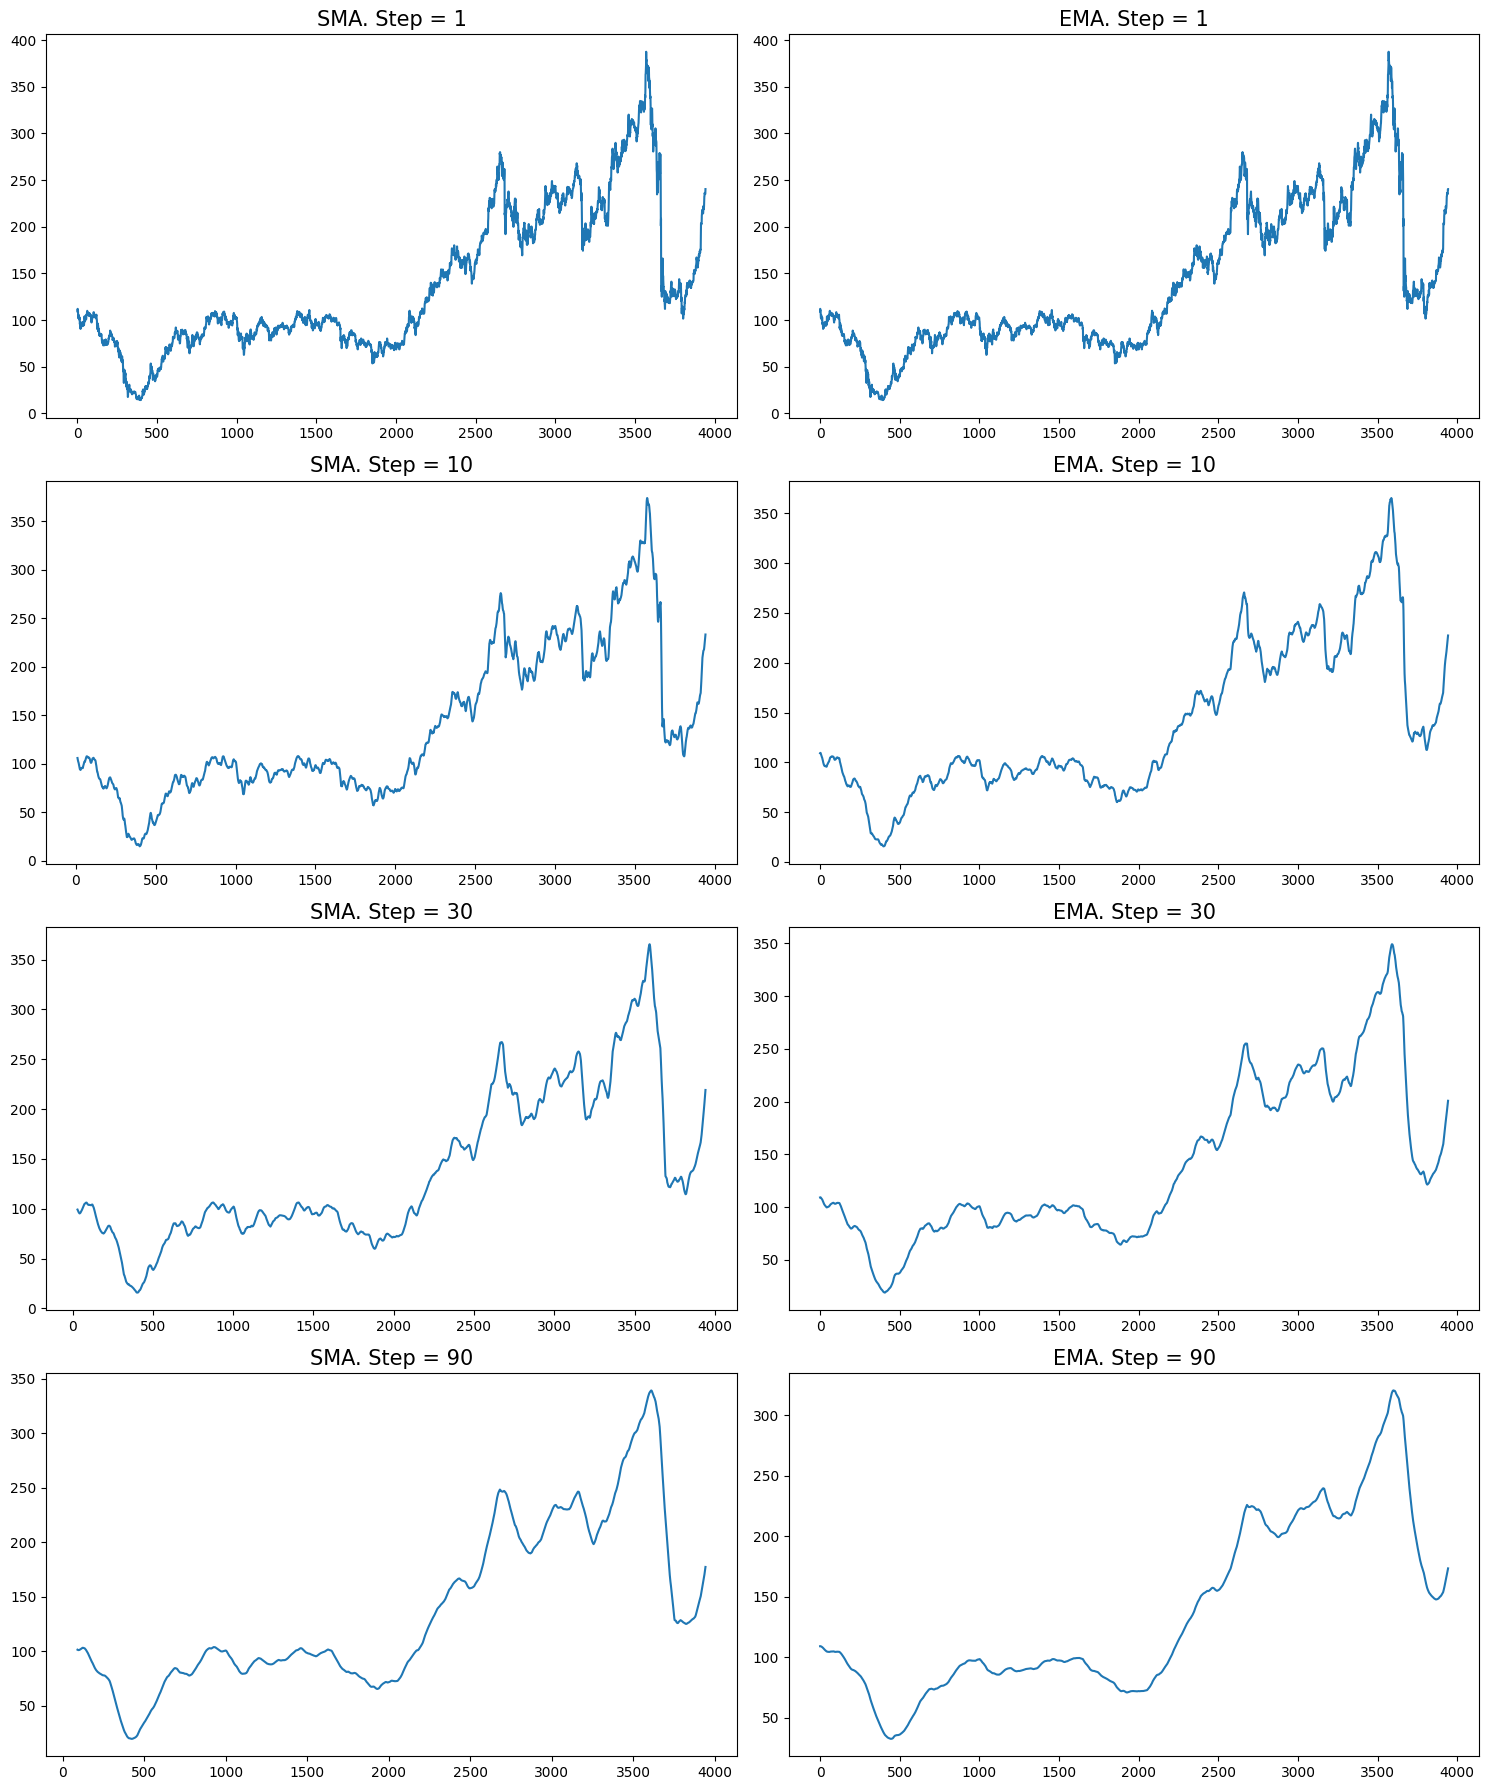

In [12]:
from calculator.stats import moving_average, exp_moving_average

plt.gcf().set_size_inches(15, 18)

for index, step in enumerate([1, 10, 30, 90]):
    plt.subplot(4, 2, 2 * index + 1)
    plt.title(f"SMA. Step = {step}", fontsize=15)
    plt.plot(range(len(df)), moving_average(df.close, step))

    plt.subplot(4, 2, 2 * index + 2)
    plt.title(f"EMA. Step = {step}", fontsize=15)
    plt.plot(range(len(df)), exp_moving_average(df.close, step))

plt.savefig('../pictures/MA', bbox_inches='tight')
plt.tight_layout();

In [13]:
df['return_close'] = df.close.pct_change()
df = df.dropna()

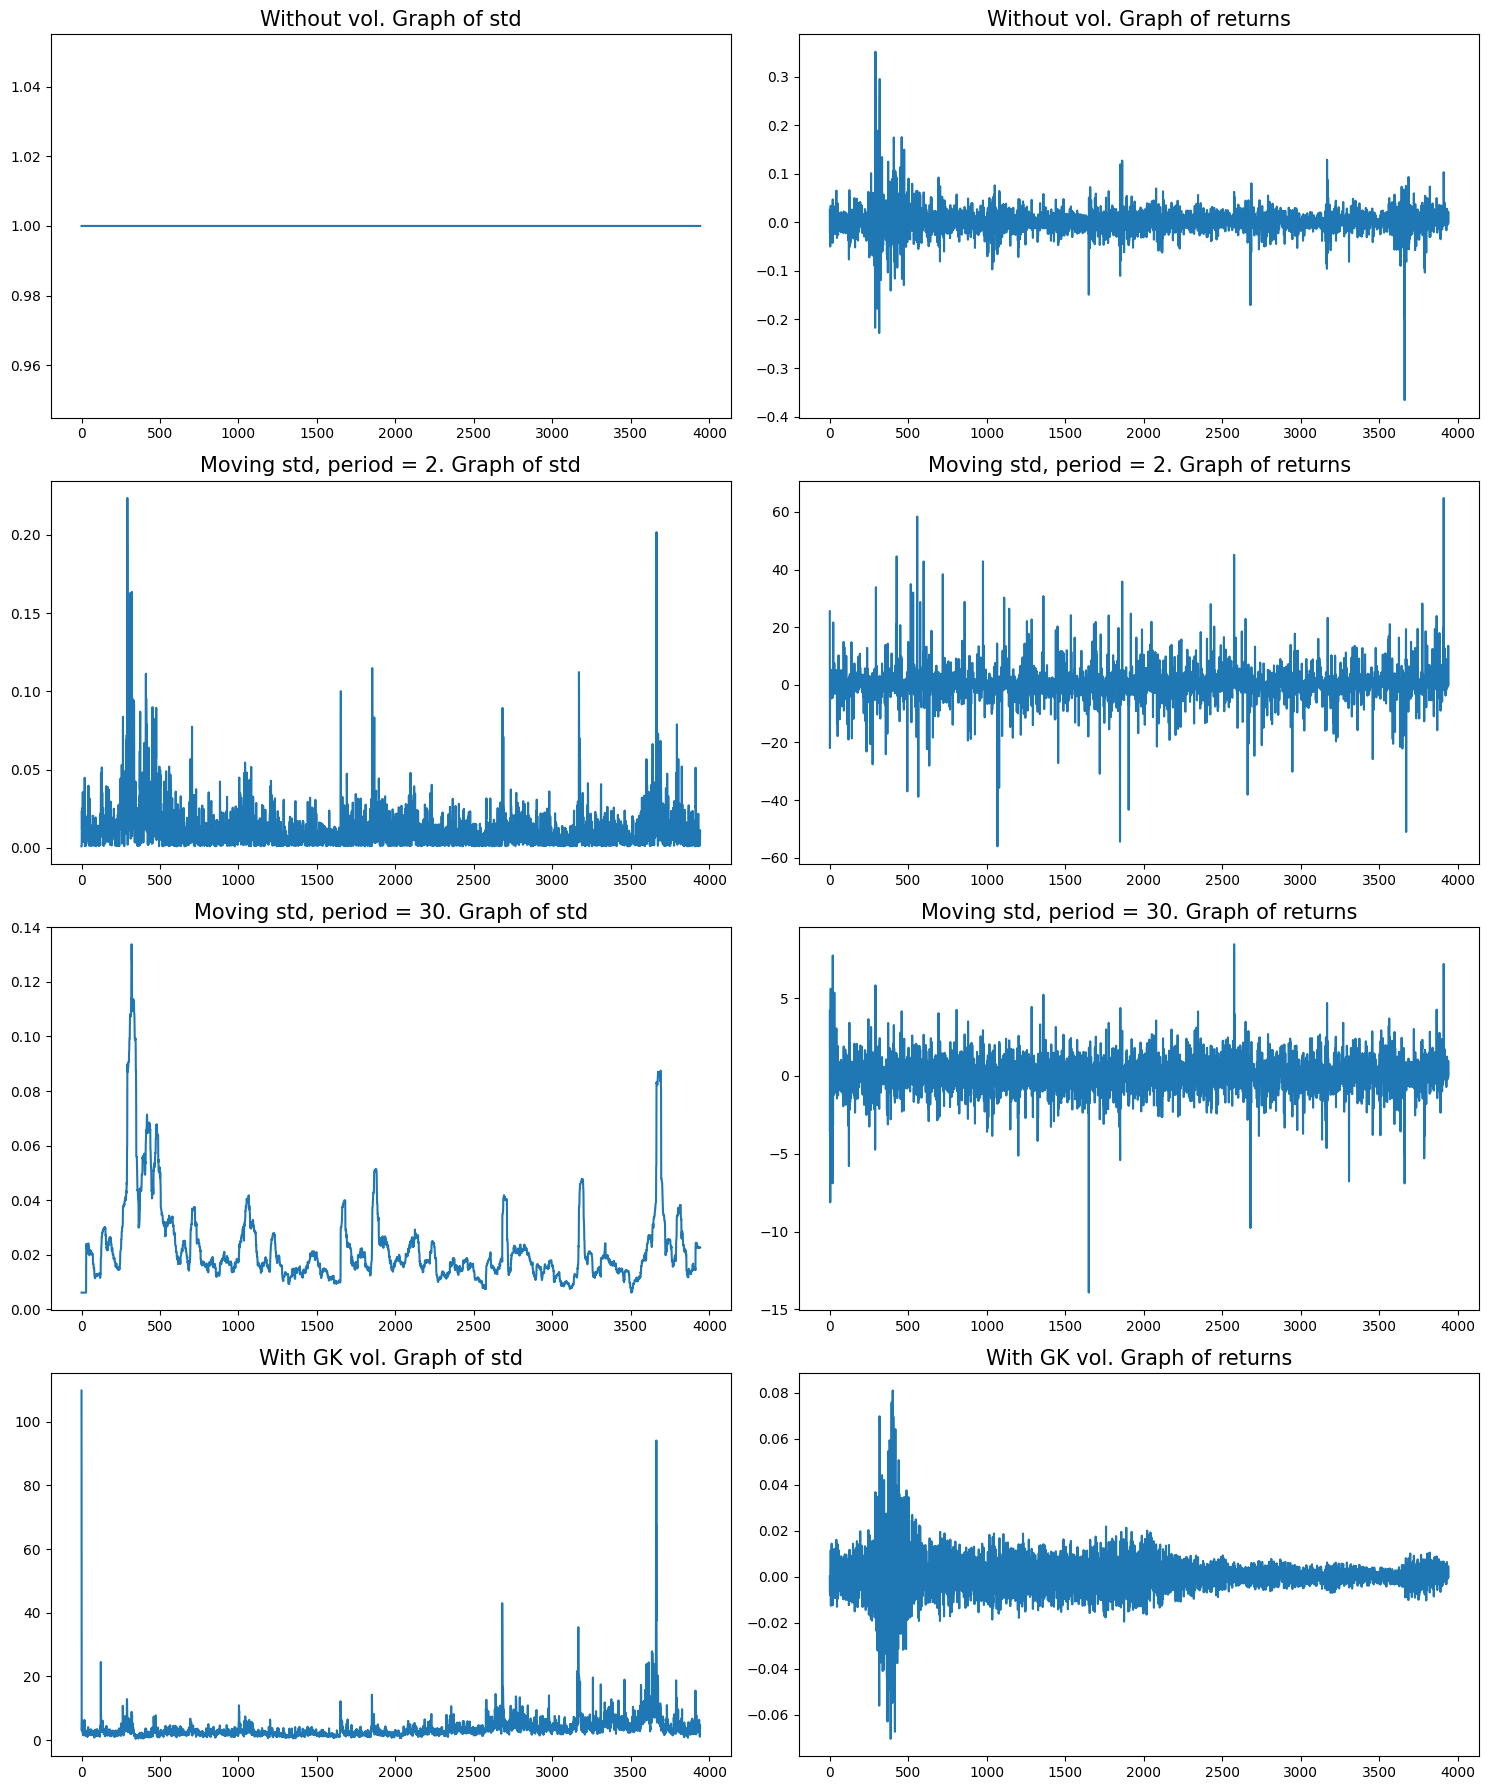

In [15]:
from calculator.stats import gk_std, moving_std

plt.gcf().set_size_inches(15, 18)

plt.subplot(4, 2, 1)
plt.title("Without vol. Graph of std", fontsize=15)
plt.plot(range(len(df)), np.ones_like(df.return_close))

plt.subplot(4, 2, 2)
plt.title("Without vol. Graph of returns", fontsize=15)
plt.plot(range(len(df)), df.return_close)

for index, step in zip([1, 2], [2, 30]):
    std = moving_std(df.return_close, step, 1e-3)
    plt.subplot(4, 2, 2 * index + 1)
    plt.title(f"Moving std, period = {step}. Graph of std", fontsize=15)
    plt.plot(range(len(df)), std)

    plt.subplot(4, 2, 2 * index + 2)
    plt.title(f"Moving std, period = {step}. Graph of returns", fontsize=15)
    plt.plot(range(len(df)), df.return_close / std)

plt.subplot(4, 2, 7)
std = gk_std(df, 1e-3)
plt.title("With GK vol. Graph of std", fontsize=15)
plt.plot(range(len(df)), std)

plt.subplot(4, 2, 8)
plt.title(f"With GK vol. Graph of returns", fontsize=15)
plt.plot(range(len(df)), df.return_close / std)

plt.savefig('../pictures/vol', bbox_inches='tight')
plt.tight_layout();

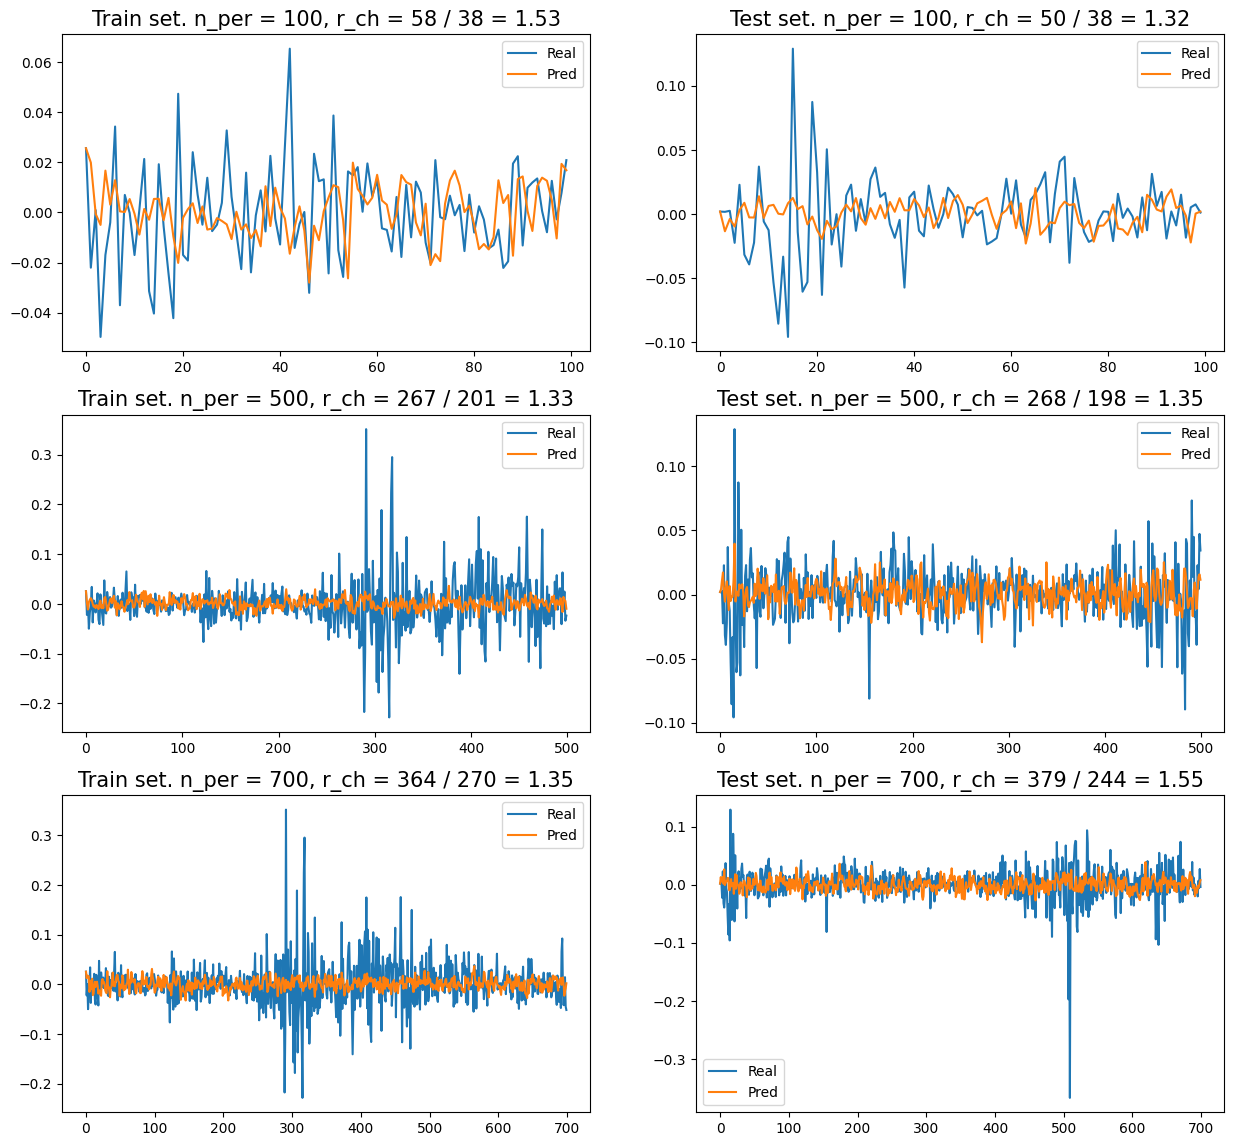

In [16]:
from calculator.ou_process import simulate_ou_process, estimate_params

def n_changes(series: np.array) -> int:
    return int(np.sum(np.abs(np.diff(np.sign(series))) > 0))

plt.gcf().set_size_inches(15, 14)
train_length = int(len(df) * 0.8)
X_train, X_test = np.array(df.return_close)[:train_length], np.array(df.return_close)[train_length:]
params = estimate_params(X_train)

for index, n_periods in enumerate([100, 500, 700]):
    plt.subplot(3, 2, 2 * index + 1)
    y_true = df.return_close.iloc[:n_periods]
    y_pred = simulate_ou_process(n_periods, params=params, x0=df.return_close.iloc[0])
    n_true = n_changes(y_true); n_pred = n_changes(y_pred)
    plt.title(f"Train set. n_per = {n_periods}, r_ch = {n_true} / {n_pred} = {n_true / n_pred:.2f}",fontsize=15)
    plt.plot(range(n_periods), y_true, label='Real')
    plt.plot(range(n_periods), y_pred, label='Pred')
    plt.legend()

    plt.subplot(3, 2, 2 * index + 2)
    y_true = df.return_close.iloc[train_length:train_length + n_periods]
    y_pred = simulate_ou_process(n_periods, params=params, x0=df.return_close.iloc[train_length])
    n_true = n_changes(y_true); n_pred = n_changes(y_pred)
    plt.title(f"Test set. n_per = {n_periods}, r_ch = {n_true} / {n_pred} = {n_true / n_pred:.2f}", fontsize=15)
    plt.plot(range(n_periods), y_true, label='Real')
    plt.plot(range(n_periods), y_pred, label='Pred')
    plt.legend()

plt.savefig('../pictures/ou_process', bbox_inches='tight');

In [17]:
params

OUParams(alpha=0.9966065738211776, beta=0.02768652872866581, gamma=0.0006338866212577374)